In [1]:
import warnings
import pandas as pd
import pyspark
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import FloatType
from pyspark.sql.functions import when, col, to_date, lag
from pyspark.sql.functions import to_timestamp, count, isnan, isnull, mean, rand

warnings.filterwarnings("ignore")

In [2]:
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"

# Spark version 3.2.3
# MongoDB version 6.0.5
# Java Version 11

# create a spark session
# Jars dependencies available in maven repository
# https://mvnrepository.com/search?q=mongodb-driver-sync
spark = SparkSession.builder \
    .appName('Tweets') \
    .config("spark.mongodb.read.connection.uri", mongo_uri) \
    .config("spark.mongodb.write.connection.uri", mongo_uri) \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.1.1") \
    .config("spark.jars.packages", "org.mongodb:mongodb-driver-core:4.9.1") \
    .config("spark.jars.packages", "org.mongodb:mongodb-driver-sync:4.9.1") \
    .config("spark.jars.packages", "org.mongodb:bson:4.9.1") \
    .getOrCreate()


In [3]:
# read data from mongodb collection "tweets" into a dataframe "df"
df_tweets = spark.read \
    .format("mongodb") \
    .option("connection.uri", mongo_uri) \
    .option("database", "ca2") \
    .option("collection", "vaccin_tweets_2_202004") \
    .load()

df_sentiment = spark.read \
    .format("mongodb") \
    .option("connection.uri", mongo_uri) \
    .option("database", "ca2") \
    .option("collection", "vaccin_tweets_2_202004_sentiment") \
    .load()

In [4]:
# Create a new column 'is_retweet' based on the presence of 'RT' in the 'text' column
df_tweets = df_tweets.withColumn("is_retweet", (col("text").like("RT%")).cast("integer"))

In [5]:
df_tweets.show()

+-------------------+-----------+--------------------+--------------------+-------------+----------+
|                _id|coordinates|                text|           timestamp| timestamp_ms|is_retweet|
+-------------------+-----------+--------------------+--------------------+-------------+----------+
|1212278787553058817|       null|@WHO: Healthy res...|2020-01-01 07:46:...|1577864760660|         0|
|1212280247170654208|       null|RT @LotusOak2: #M...|2020-01-01 07:51:...|1577865108660|         1|
|1212282537252253697|       null|RT @MaryamHenein:...|2020-01-01 08:00:...|1577865654658|         1|
|1212309506660716544|       null|@stopvaccinating ...|2020-01-01 09:48:...|1577872084666|         0|
|1212329282799718400|       null|RT @LotusOak2: #S...|2020-01-01 11:06:...|1577876799665|         1|
|1212339789535383552|       null|Childhood Vaccina...|2020-01-01 11:48:...|1577879304666|         0|
|1212355987916677120|       null|@Wallace_Noll @Ro...|2020-01-01 12:52:...|1577883166661|  

In [6]:
df_sentiment.show()

+-------------------+-------------------+---------+
|                _id|      s_probability|sentiment|
+-------------------+-------------------+---------+
|1255385449109037058| 0.8120726346969604|  neutral|
|1255387944732557315| 0.9099276065826416|  neutral|
|1255388825532203009| 0.4517519772052765|  neutral|
|1255390373234556929| 0.9485631585121155|  neutral|
|1255391195313954820| 0.8417240977287292|  neutral|
|1255391367293014018| 0.5158259868621826|  neutral|
|1255393007244840962| 0.8417240977287292|  neutral|
|1255393422480936960| 0.7700037360191345| positive|
|1255394026473340928| 0.5632174611091614| positive|
|1255394122925514755| 0.8323110342025757|  neutral|
|1255394148112269317| 0.5489822626113892|  neutral|
|1255396580825366528| 0.8595384359359741|  neutral|
|1255397075728072706|  0.877598226070404| negative|
|1255397323213070339| 0.9453902840614319| positive|
|1255397356767522823| 0.7315185070037842|  neutral|
|1255398954793152512| 0.8410886526107788|  neutral|
|12554048981

In [7]:
# Join data frames
df = df_tweets.join(df_sentiment, on="_id", how="inner")


In [8]:
# Convert timestamp to a format usable for analysis
df = df.withColumn("timestamp", to_timestamp(df["timestamp"]))
df = df.withColumn("date", df["timestamp"].cast("date"))
df = df.withColumn("s_probability", col("s_probability").cast("float"))

In [9]:
df.createOrReplaceTempView("tweets")
spark.sql("SELECT MAX(date) maxdate, MIN(date) mindate FROM tweets").show()

+----------+----------+
|   maxdate|   mindate|
+----------+----------+
|2021-04-01|2020-01-01|
+----------+----------+



## Initial dates

In [10]:
# Filter 1 year data
start_date_str = '2020-04-01'
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")

df = df.filter(f"date >= date'{start_date_str}'")

In [11]:
df.createOrReplaceTempView("tweets")
spark.sql("SELECT MAX(date) maxdate, MIN(date) mindate FROM tweets").show()

+----------+----------+
|   maxdate|   mindate|
+----------+----------+
|2021-04-01|2020-04-01|
+----------+----------+



In [12]:
# Encode sentiment and calculate weights score
df = df.withColumn("sentiment_encoded", 
                    when(col("sentiment") == "positive", 1)
                   .when(col("sentiment") == "negative", -1)
                   .otherwise(0))

df = df.withColumn("sentiment_score", 
                    when(col("sentiment_encoded") != 0, col("sentiment_encoded") * col("s_probability"))
                   .otherwise(col("s_probability")))

df = df.withColumn("sentiment_encoded", col("sentiment_encoded").cast("int"))
df = df.withColumn("sentiment_score", col("sentiment_score").cast("float"))

In [13]:
df.describe()

DataFrame[summary: string, _id: string, text: string, timestamp_ms: string, is_retweet: string, s_probability: string, sentiment: string, sentiment_encoded: string, sentiment_score: string]

In [14]:
df[["date","is_retweet","sentiment_encoded","s_probability","sentiment_score"]].show()

+----------+----------+-----------------+-------------+---------------+
|      date|is_retweet|sentiment_encoded|s_probability|sentiment_score|
+----------+----------+-----------------+-------------+---------------+
|2020-04-01|         1|                0|    0.9046114|      0.9046114|
|2020-04-04|         0|                0|   0.90104806|     0.90104806|
|2020-04-04|         0|                0|   0.93321073|     0.93321073|
|2020-04-05|         1|                0|     0.607992|       0.607992|
|2020-04-05|         1|               -1|    0.6045877|     -0.6045877|
|2020-04-05|         1|               -1|   0.78245074|    -0.78245074|
|2020-04-05|         1|                0|   0.60876995|     0.60876995|
|2020-04-06|         1|                0|    0.8554339|      0.8554339|
|2020-04-06|         1|                0|    0.8586964|      0.8586964|
|2020-04-06|         1|                0|     0.695748|       0.695748|
|2020-04-07|         1|                0|    0.6178516|      0.6

In [15]:
# Aggregate sentiment by date and retweet rates to capture the retweet feature
df_grouped = df.groupBy("date").agg(mean("sentiment_score").alias("avg_sentiment_score"))
df_grouped = df.groupBy("date").agg(mean("sentiment_score").alias("avg_sentiment_score"), 
                                    mean("is_retweet").alias("retweet_rate"))

# Ensure order of data
df_grouped = df_grouped.orderBy("date")


In [16]:
df_grouped.show()

+----------+--------------------+------------------+
|      date| avg_sentiment_score|      retweet_rate|
+----------+--------------------+------------------+
|2020-04-01| 0.43742156782369507| 0.632183908045977|
|2020-04-02|  0.4164388195311208|0.6188925081433225|
|2020-04-03| 0.42928661719938743|0.6416464891041163|
|2020-04-04| 0.20674441452045364|0.7191235059760956|
|2020-04-05| 0.22949271021144732|0.6910714285714286|
|2020-04-06|  0.3333175753254488|0.6746987951807228|
|2020-04-07| 0.48902177778964345|0.7805851063829787|
|2020-04-08|  0.3319369952307581|  0.67590618336887|
|2020-04-09|  0.2574529005626662|0.6836283185840708|
|2020-04-10| 0.31918193961675173|0.7875399361022364|
|2020-04-11|  0.3335993493942016|0.7834224598930482|
|2020-04-12|  0.2845153512514156|0.7695652173913043|
|2020-04-13|  0.2336201870930381|        0.69140625|
|2020-04-14| 0.42815437484713437|0.6368932038834951|
|2020-04-15| 0.29408319351894785|0.6394557823129252|
|2020-04-16|-0.10396978441922942|0.73006134969

## Daily seasonality

In [17]:
def build_vector(lag_periods, df_grouped, skip_to):
    window = Window.orderBy("date")
    
    # Create groups for 1,2,3,4,5,6,7 weekly seasons.
    for i in lag_periods:
        df_grouped = df_grouped.withColumn(f'sentiment_score_lag_{i}', lag(col('avg_sentiment_score'), i).over(window))
        
    # Filter out the first 7 rows with NAN
    filter_d = f"date > date'{skip_to}'"
    df_grouped = df_grouped.filter(filter_d)
    
    input_cols = [f'sentiment_score_lag_{i}' for i in lag_periods]
    input_cols.append("retweet_rate")
    input_cols
    
    # Assembler Vector - A feature transformer that merges multiple columns into a vector column.
    # https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html
    va = VectorAssembler(
        inputCols=input_cols,
        outputCol='features')
    
    return va.transform(df_grouped)


## Linear regression

# Daily 

In [18]:
va_df = build_vector([1,2,3,4,5,6,7], df_grouped, (start_date + timedelta(days=7)))

In [19]:
va_df.select(["date"]).show(1)

+----------+
|      date|
+----------+
|2020-04-09|
+----------+
only showing top 1 row



In [20]:
# Prepare train and test datasets
split_date = "2021-02-01"
train = va_df.filter(va_df.date <= split_date)
test = va_df.filter(va_df.date > split_date)

# Linear regression model
lr = LinearRegression(featuresCol='features', labelCol='avg_sentiment_score')

# Fit the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate model
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='avg_sentiment_score')

print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2) 
print(f"RMSE: {evaluator.evaluate(predictions)}")


MSE:  0.01418337871080279
MAE:  0.08759708836374087
R-squared:  0.11336422945487701
RMSE: 0.0750653100156366


## Plot predictions

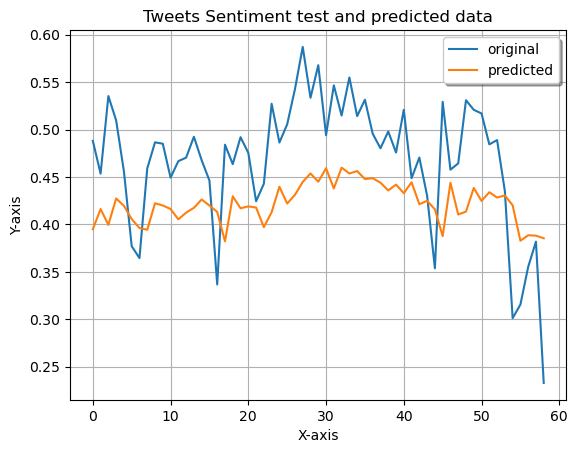

In [21]:
mdata = lr_model.transform(test)
x_ax = range(0, mdata.count())
y_pred = mdata.select("prediction").collect()
y_orig = mdata.select("avg_sentiment_score").collect()

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Tweets Sentiment test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## Feature importance

In [22]:
def calculate_permutation_feature_importance(model, metric_name, df, features):
    evaluator = RegressionEvaluator(labelCol="avg_sentiment_score", predictionCol="prediction", metricName=metric_name)
    
    base_rmse = evaluator.evaluate(model.transform(df))
    
    importances = {}
    for feature in features:
        df_temp = df.withColumn(feature, rand())
        rmse = evaluator.evaluate(model.transform(df_temp))
        importances[feature] = base_rmse - rmse
        
    return importances

features = ["sentiment_score_lag_1", "sentiment_score_lag_2", "sentiment_score_lag_3", 
            "sentiment_score_lag_4", "sentiment_score_lag_5", "sentiment_score_lag_6", 
            "sentiment_score_lag_7", "retweet_rate"]

importances = calculate_permutation_feature_importance(lr_model, "rmse", va_df, features)

In [32]:
importances

{'sentiment_score_lag_1': 0.0,
 'sentiment_score_lag_2': 0.0,
 'sentiment_score_lag_3': 0.0,
 'sentiment_score_lag_4': 0.0,
 'sentiment_score_lag_5': 0.0,
 'sentiment_score_lag_6': 0.0,
 'sentiment_score_lag_7': 0.0,
 'retweet_rate': 0.0}

## Weekly seasonlaity 1, 7, 14, 21, 28 days:

In [23]:
va_df = build_vector([1, 7, 14, 21, 28, 35], df_grouped, (start_date + timedelta(days=35)))

In [24]:
va_df.select(["date"]).show(1)

+----------+
|      date|
+----------+
|2020-05-07|
+----------+
only showing top 1 row



In [25]:
# Prepare train and test datasets
split_date = "2021-02-01"
train = va_df.filter(va_df.date <= split_date)
test = va_df.filter(va_df.date > split_date)

# Linear regression model
lr = LinearRegression(featuresCol='features', labelCol='avg_sentiment_score')

# Fit the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate model
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='avg_sentiment_score')

print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2) 
print(f"RMSE: {evaluator.evaluate(predictions)}")


MSE:  0.014169827671004354
MAE:  0.08830606072823885
R-squared:  0.1359746260840342
RMSE: 0.07685884606047189


In [26]:
train.count(),test.count()

(248, 59)

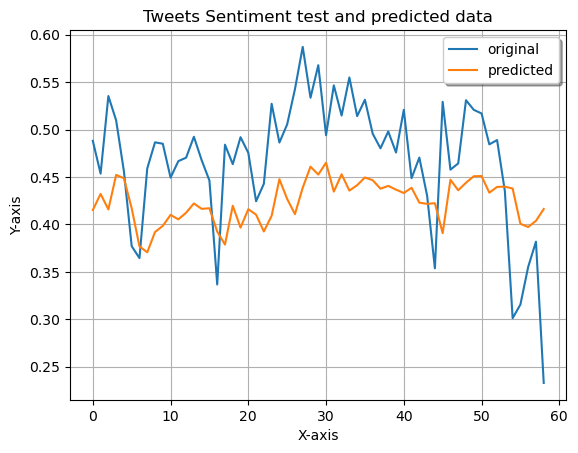

In [27]:
mdata = lr_model.transform(test)
x_ax = range(0, mdata.count())
y_pred = mdata.select("prediction").collect()
y_orig = mdata.select("avg_sentiment_score").collect()

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Tweets Sentiment test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

## Biweekly seasonality 1, 14, 28, 42 days:

In [28]:
va_df = build_vector([1, 14, 28, 42, 56, 70, 84], df_grouped, (start_date + timedelta(days=84+3)))

In [29]:
# Prepare train and test datasets
split_date = "2021-02-01"
train = va_df.filter(va_df.date <= split_date)
test = va_df.filter(va_df.date > split_date)

# Linear regression model
lr = LinearRegression(featuresCol='features', labelCol='avg_sentiment_score')

# Fit the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)

# Evaluate model
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='avg_sentiment_score')

print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2) 
print(f"RMSE: {evaluator.evaluate(predictions)}")


MSE:  0.01268733894192353
MAE:  0.0841947357052909
R-squared:  0.09487849261546555
RMSE: 0.07621273910676328


In [30]:
train.count(), test.count()

(197, 59)

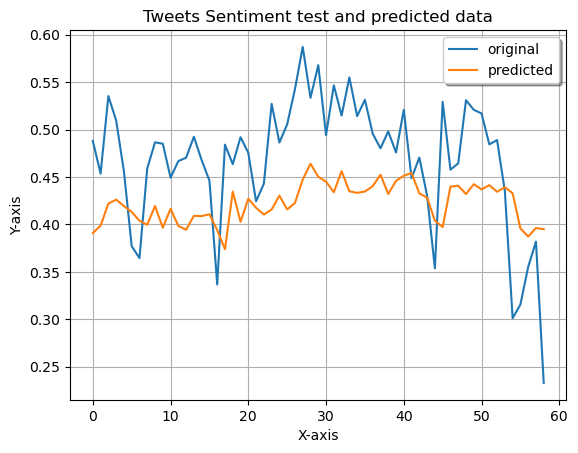

In [31]:
mdata = lr_model.transform(test)
x_ax = range(0, mdata.count())
y_pred = mdata.select("prediction").collect()
y_orig = mdata.select("avg_sentiment_score").collect()

plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Tweets Sentiment test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 